In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784' , as_frame=False)

# X => 70000 x 784 feature matrix. Each row is a image (28x28 pixel => 784) of a handwritten number. Feature represents the pixel's intensity (0-255)
# y => 70000 x 1 vector. Each row has the corresponding number to the sample's image
X , y = mnist.data , mnist.target

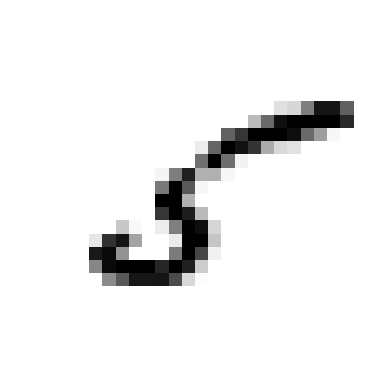

In [43]:
#implement a function to show the image
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28 , 28)
    plt.imshow(image , cmap="binary")
    plt.axis("off")
    
some_digit = X[11]
plot_digit(some_digit)
plt.show()

In [14]:
#before we begin inspecting the data => separate between train and test data
X_train , X_test , y_train , y_test = X[:60000] , X[60000:] , y[:60000] , y[60000:]

In [15]:
#Lets train only a simple "binary classifier" capable to distinguishing between just to classes "5" and "non-5"
y_train_5 = (y_train == '5') #True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [19]:
#using a stochastic gradient descent classifier (SGD classifier). Is efficient on large datasets
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train , y_train_5)

SGDClassifier(random_state=42)

In [42]:
#now lets use it to detect images of the number 5:
sgd_clf.predict([X[11]])

array([ True])

In [44]:
#lets measure the accuracy of our classifier. Using "confusion matrix"
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf , X_train , y_train_5 , cv=3)
cm = confusion_matrix(y_train_5 , y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [45]:
#using precision and recall to compute the classifier's metrics
from sklearn.metrics import precision_score , recall_score

print("Precision score: " + str(precision_score(y_train_5 , y_train_pred)))
print("Recall score: " + str(recall_score(y_train_5 , y_train_pred)))

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


Means: When our classifier claims that an image represents a 5, it is correct only in 83,5% of the time.
And it only detects 65.1% of all 5s.

In [46]:
#Computing the F1 score to get a single metric which uses precision and recall scores
from sklearn.metrics import f1_score

print("F1 score: " + str(f1_score(y_train_5 , y_train_pred)))

F1 score: 0.7325171197343847


Precision and recall are dependent from each other, known as "precision/recall-trade-off"
By changing the threshold of the classifier's decision function, we change the precision/recall.
The higher the threshold, the lower the recall, but in general the ghiher the precision (and vice versa).

In [50]:
#One way to decide which threshold to use is by using the cross_val_predict function:
y_scores = cross_val_predict(sgd_clf , X_train , y_train_5 , cv=3 ,
                             method="decision_function")

In [51]:
#with these scores we will use precision_recall_curve to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions , recalls , thresholds = precision_recall_curve(y_train_5 , y_scores)

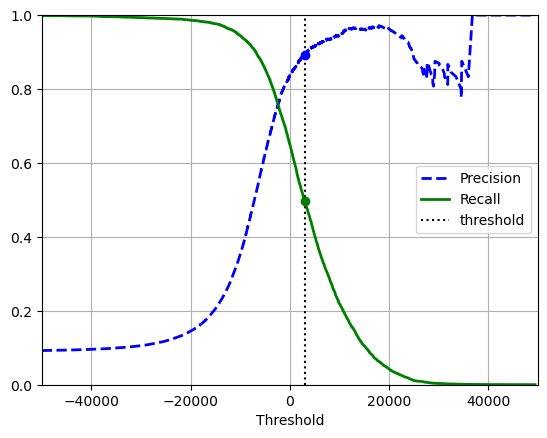

In [56]:
#using matplotlib to show precision and recall function. Example: threshold==3000:
threshold = 3000
plt.plot(thresholds , precisions[:-1] , "b--" , label="Precision" , linewidth=2)
plt.plot(thresholds , recalls[:-1] , "g-" , label="Recall" , linewidth=2)
plt.vlines(threshold , 0 , 1.0 , "k" , "dotted" , label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

Means: At a threshold of 3000, the precision would be around 90% and the recall around 50%.

Let's find a threshold for which we get 90% precision:

In [57]:
#using NumPy's argmax() to get the first index of the max value
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [59]:
#quick and dirty prediction:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5 , y_train_pred_90)

0.9000345901072293

In [61]:
recall_at_90_precision = recall_score(y_train_5 , y_train_pred_90)
recall_at_90_precision

0.4799852425751706

=> We got our threshold: 3370 , the precision is at 90% and the recall at 47%

==================

In [62]:
#Using the ROC Curve as another common tool used with binary classifier to rate them
from sklearn.metrics import roc_curve

fpr , tpr , thresholds = roc_curve(y_train_5 , y_scores)

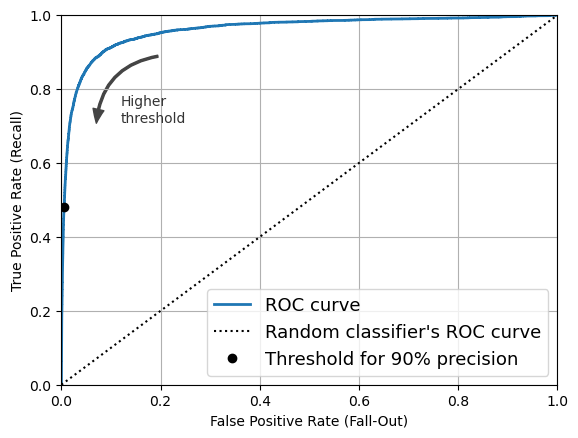

In [69]:
#plotting the ROC curve
import matplotlib.patches as patches

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax() #using <= because thresholds are listed in decreasing order
tpr_90 , fpr_90 = tpr[idx_for_threshold_at_90] , fpr[idx_for_threshold_at_90]

plt.plot(fpr , tpr , linewidth=2 , label="ROC curve")
plt.plot([0 , 1] , [0 , 1] , 'k:' , label="Random classifier's ROC curve")
plt.plot([fpr_90] , [tpr_90] , "ko" , label="Threshold for 90% precision")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

In [70]:
#calculate the ROC area under the curve (AUC). This useful to compare classifiers.
#A perfect classifier would have ROC AUC equal to 1. A random classifier's ROC AUC would be equal to 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5 , y_scores)

0.9604938554008616

In [71]:
#Using a RandomForestClassifier to compare its PR curve and F1 score against our SGDClassifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf , X_train , y_train_5 , cv=3 , method="predict_proba")

In [76]:
#the second column of y_probas_forest contains the estimated probabilities for the positive class.
#Let's pass them to the precision_recall_curve() function:
y_scores_forest = y_probas_forest[: , 1] # mx1 vector
precisions_forest , recalls_forest , thresholds_forest = precision_recall_curve(y_train_5 , y_scores_forest)

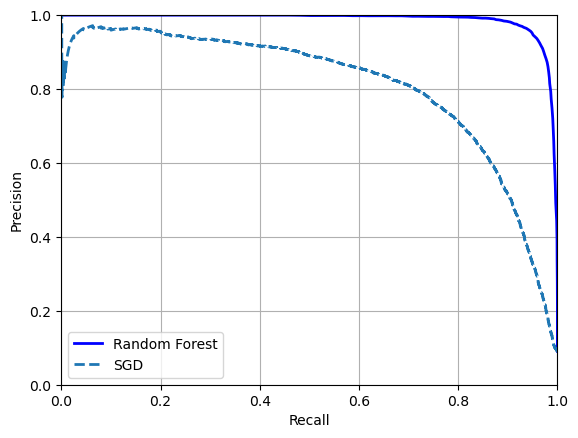

In [78]:
#plot PR-curve of randomforestclassifier vs SGDClassifier
plt.plot(recalls_forest , precisions_forest , "b-" , linewidth=2 , label="Random Forest")
plt.plot(recalls , precisions , "--" , linewidth=2 , label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

RandomForestClassifier looks much better compared to the performance of SGDClassifier.

In [87]:
#lets take a look at RandomForest' F1 and ROC AUC score
y_train_pred_forest = y_probas_forest[: , 1] >= 0.5 #positive proba >= 50%

print("Precision score: " + str(precision_score(y_train_5 , y_train_pred_forest)))
print("Recall score: " + str(recall_score(y_train_5 , y_train_pred_forest)))
print("F1 score: " + str(f1_score(y_train_5 , y_train_pred_forest)))
print("ROC AUC score: " + str(roc_auc_score(y_train_5 , y_scores_forest)))

Precision score: 0.9897468089558485
Recall score: 0.8725327430363402
F1 score: 0.9274509803921569
ROC AUC score: 0.9983436731328145


Conclusion: RandomForestClassifier performs way better for our task!

# Multiclass classification

In [89]:
#using a suppport vector machine classifier
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000] , y_train[:2000])

SVC(random_state=42)

In [90]:
svm_clf.fit(X_train , y_train)

SVC(random_state=42)

In [93]:
#How to force scikit-learn to use one-versus-one or one-versus-the-rest learning
#use OneVsOneClassifier or OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000] , y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [95]:
#check number of trained classifiers
len(ovr_clf.estimators_)

10

### Train SGDClassifier on multiclass dataset

In [96]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train , y_train)
sgd_clf.predict([X_train[0]])

array(['3'], dtype='<U1')

Predicted "3" is wrong. Should be "5". Scikit-Learn used OvR strategy here. Let's see whether we can improve it.

In [97]:
sgd_clf.decision_function([X_train[0]]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

We can see, that the classifier is not confident about its prediction. Almost all scores are very negative.

In [99]:
#evaluate the model using cross_val_score
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf , X_train , y_train , cv=3 , scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85,8% on all test folds. By using scaled inputs, the accuracy should get even better:

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf , X_train_scaled , y_train , cv=3 , scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error analysis

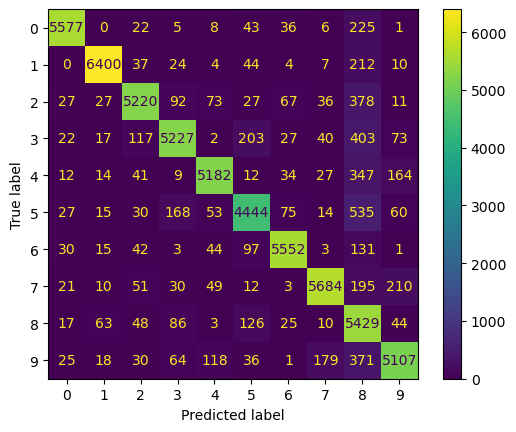

In [101]:
#Start error analysis by computing the ConfusionMatrix and plot it
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf , X_train_scaled , y_train , cv=3)
ConfusionMatrixDisplay.from_predictions(y_train , y_train_pred)
plt.show()

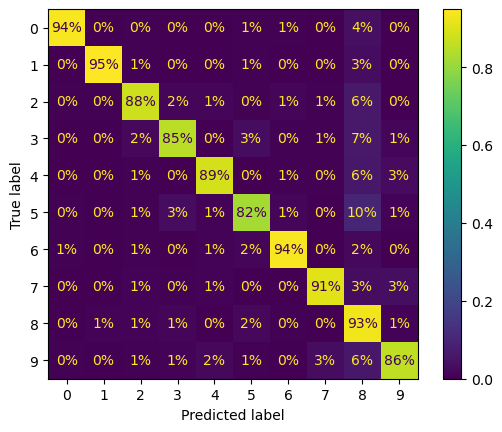

In [104]:
#better show normalized confusion matrix:
ConfusionMatrixDisplay.from_predictions(y_train , y_train_pred , normalize="true" , values_format=".0%")
plt.show()

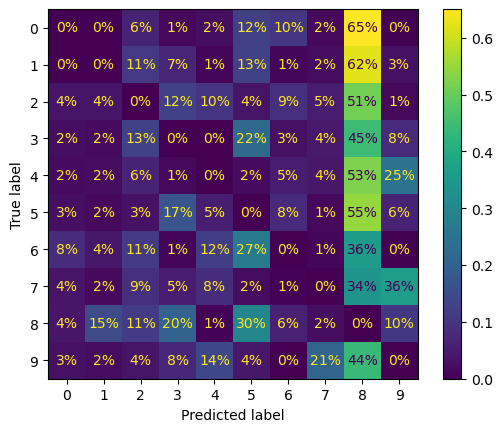

In [107]:
#Now errors normalized by row to highlight errors
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train , y_train_pred , 
                                        sample_weight=sample_weight , normalize="true" , 
                                        values_format=".0%")
plt.show()

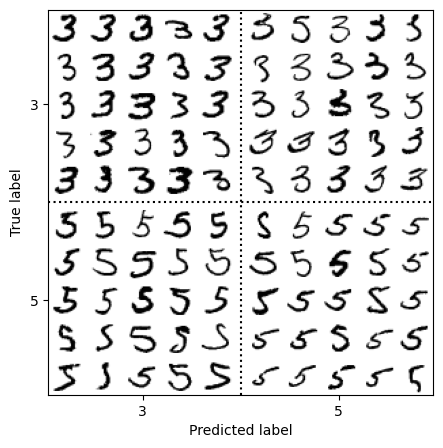

In [108]:
#Analyzing individual errors to gain insights into what the classfier is doing and why it is failing
#Let's plot examples of 3s and 5s:
cl_a , cl_b = '3' , '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

# Multilabel Classification

In [112]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier


#create y_multilabel that contains to target labels. 1. => whether the number is >= 7 and 2. the number is odd
#then train this via KNNClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large , y_train_odd]

In [111]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train , y_multilabel)

KNeighborsClassifier()

In [113]:
knn_clf.predict([X_train[0]])

array([[False,  True]])

The prediction is true for a 5 for testing.

In [114]:
#Many ways to evaluate a multilabel classifer. One is to measure the F1 score for each individual label
#then compute the average score
y_train_knn_pred = cross_val_predict(knn_clf , X_train , y_multilabel , cv=3)
f1_score(y_multilabel , y_train_knn_pred , average="macro")

0.9764102655606048

In [115]:
#Example of using a ClassifierChain when a classifier does not support multilabel classifiction
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC() , cv=5 , random_state=42)
chain_clf.fit(X_train , y_multilabel)

ClassifierChain(base_estimator=SVC(), cv=5, random_state=42)

In [116]:
chain_clf.predict([X_train[0]])

array([[0., 1.]])

# Multioutput Classification

In [117]:
#Example: remove noise from images. The classifier will take as input a nousy digit image and will output a
#clean digit image, represented as an array of pixel intensities:
#one label per pixel and each label can have multiple values (pixel intensity ranges from 0-255)
rng = np.random.default_rng(seed=42)
noise_train = rng.integers(0 , 100)
X_train_mod = X_train + noise_train
noise_test = rng.integers(0 , 100 , (len(X_test) , 784))
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

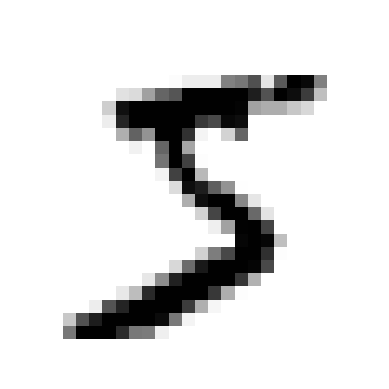

In [118]:
plot_digit(X_train_mod[0])
plt.show()